In [1]:
import io, os, re, logging
import requests, tqdm, tarfile, itertools, html, time
from dateparser.date import DateDataParser
from dateparser import parse

import numpy as np
import pandas as pd
import dask.dataframe as dd

import plotly.express as px
import plotly.graph_objects as go

# Import Dataset

In [2]:
shots_df = pd.read_parquet("../data/raw/visualizercoffee_72877shots_2021-11-11_cleaned.parquet")
shots_df

,id,profile_title,user_id,drink_tds,drink_ey,espresso_enjoyment,bean_weight,drink_weight,grinder_model,grinder_setting,...,espresso_state_change,espresso_pressure_goal,espresso_flow_weight_raw,espresso_temperature_mix,espresso_water_dispensed,espresso_temperature_goal,espresso_resistance_weight,espresso_temperature_basket,bean_age,shot_time
0,14899484-a5f8-4ccc-b372-79700c8150ae,TurboBloom,8d827d10-510f-4475-bd54-63c93b275c16,0.0,0.0,80.0,15.0,35.2,P64 MP,1.4,...,"[0.0, 10000000.0, 10000000.0, 10000000.0, 1000...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[86.0, 86.67, 86.31, 82.06, 77.66, 74.73, 73.1...","[0.0, 0.092681884765625, 0.20140380859375, 0.3...","[86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[86.0, 85.12, 85.27, 85.49, 85.38, 85.35, 85.3...",NaN,18.493
1,76f936ee-5147-40ac-986e-f0f1be5ac97e,Best overall pressure profile,10f1e281-8fd0-4f43-94f6-d416713dabe0,0.0,0.0,0.0,18.0,36.1,bentwood,120,...,"[0.0, 10000000.0, 10000000.0, 10000000.0, 1000...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[88.0, 88.3, 85.79, 85.82, 86.44, 87.32, 88.0,...","[0.0, 0.09389038085937501, 0.18845825195312502...","[88.0, 88.0, 88.0, 88.0, 88.0, 88.0, 88.0, 88....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[88.0, 87.18, 87.39, 87.37, 87.31, 87.23, 87.0...",NaN,67.318
2,8853ae7c-5bf8-4194-93dd-462de63f1471,Default,30b3dd10-aebb-4f17-ba74-a1efcf2d51ea,0.0,0.0,0.0,NaN,40.3,None,None,...,"[0.0, 10000000.0, 10000000.0, 10000000.0, 1000...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[90.5, 89.87, 87.2, 87.69, 87.95, 87.98, 88.18...","[0.0, 0.10127563476562501, 0.20233764648437502...","[90.5, 90.5, 90.5, 90.5, 90.5, 90.5, 90.5, 90....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[90.5, 87.93, 88.21, 88.23, 88.16, 88.14, 88.1...",NaN,35.054
3,a4d7a358-fc3f-451c-92f5-756adaa4a7dd,Rao Allongé,c8c4793c-6708-4e81-90e8-6d8a5b30ceee,0.0,0.0,0.0,NaN,124.5,Niche Zero,13.5,...,"[0.0, 10000000.0, 10000000.0, 10000000.0, 1000...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[92.0, 91.63, 88.9, 87.29, 88.18, 89.33, 90.63...","[0.0, 0.094384765625, 0.19187011718750002, 0.2...","[92.0, 92.0, 92.0, 92.0, 92.0, 92.0, 92.0, 92....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[92.0, 90.0, 90.41, 90.36, 90.35, 90.44, 90.4,...",NaN,40.996
4,3ebcfff9-fb6f-47f6-a3df-affe01d55150,Londonium,db110ce3-77b7-4c92-9d18-1019c3841cc9,0.0,0.0,0.0,NaN,0.0,None,None,...,"[0.0, 10000000.0, -10000000.0, -10000000.0, -1...","[-1.0, 2.0, 2.0, 2.375, 2.625, 2.75, 2.8125, 2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[89.0, 89.64, 87.11, 87.89, 88.81, 89.41, 89.6...","[0.0, 0.09944458007812501, 0.21490478515625, 0...","[89.0, 89.0, 88.5, 88.5, 88.5, 88.5, 88.5, 88....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[89.0, 87.55, 87.81, 87.75, 87.76, 87.8, 87.74...",NaN,38.787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72872,7ecca37f-2dae-429e-9947-b3ee08793b78,Gentle and sweet,b51718ab-bc11-463d-be90-5538921b05e4,9.5,0.0,65.0,18.0,39.8,Sette 270Wi,6E,...,None,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[0.0, 0.0, -0.05, -0.05, -0.05, -0.05, -0.05, ...","[92.0, 92.79, 90.69, 88.64, 89.55, 90.82, 91.9...","[0.0, 0.0509765625, 0.111627197265625, 0.18171...","[92.0, 92.0, 92.0, 92.0, 92.0, 92.0, 92.0, 92....",None,"[92.0, 92.61, 92.53, 92.24, 91.6, 90.83, 90.06...",12.440278,26.777
72873,7bf138f6-8fb9-41c9-a513-74874115684f,Blooming Allongé,b51718ab-bc11-463d-be90-5538921b05e4,5.2,0.0,60.0,18.0,89.2,Sette 270Wi,7E,...,None,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[0.0, 0.0, -0.05, -0.05, -0.05, -0.05, -0.05, ...","[94.0, 93.37, 89.01, 90.15, 91.73, 92.96, 93.8...","[0.0, 0.05553588

In [3]:
shots_df.dtypes

id                                     object
profile_title                          object
user_id                                object
drink_tds                             float64
drink_ey                              float64
espresso_enjoyment                    float64
bean_weight                           float64
drink_weight                          float64
grinder_model                          object
grinder_setting                        object
bean_brand                             object
bean_type                              object
roast_date                     datetime64[ns]
espresso_notes                         object
roast_level                            object
bean_notes                             object
start_time                     datetime64[ns]
image_preview                          object
profile_url                            object
timeframe                              object
espresso_flow                          object
espresso_weight                   

In [4]:
shots_df["roast_level"]

0        Agtron 91
1             None
2            light
3             None
4             None
           ...    
72872         None
72873         None
72874         None
72875         None
72876         None
Name: roast_level, Length: 72877, dtype: object

# Visualize distribution of features

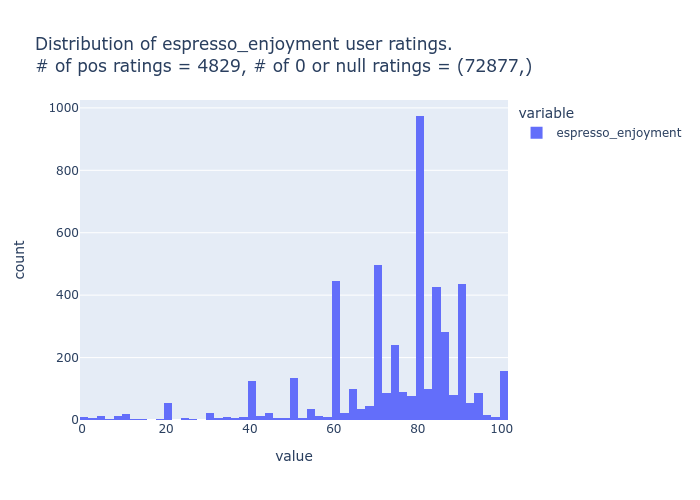

In [5]:
pos_ratings = shots_df["espresso_enjoyment"][shots_df["espresso_enjoyment"]!=0]
px.histogram(pos_ratings, 
             title=f"Distribution of espresso_enjoyment user ratings."
             f"<br># of pos ratings = {pos_ratings.shape[0]}, # of 0 or null ratings = {(shots_df['espresso_enjoyment']==0).shape}").show(renderer="png")

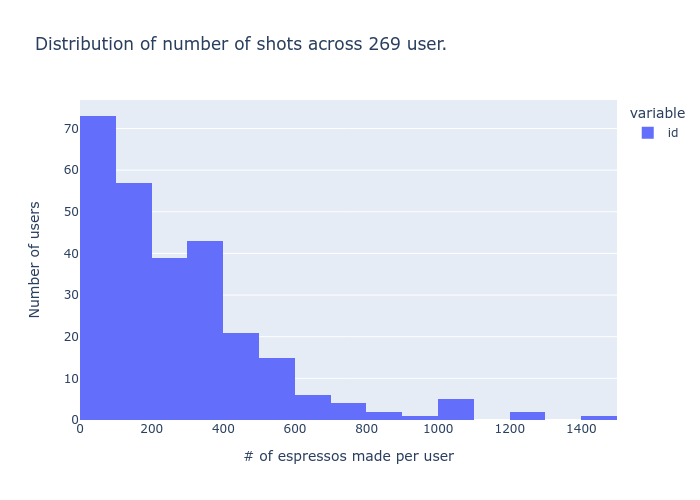

In [6]:
fig = px.histogram(shots_df.groupby("user_id")["id"].count().sort_values(), title=f"Distribution of number of shots across {shots_df['user_id'].nunique()} user.")
fig.update_layout(xaxis_title="# of espressos made per user", yaxis_title="Number of users").show(renderer="png")

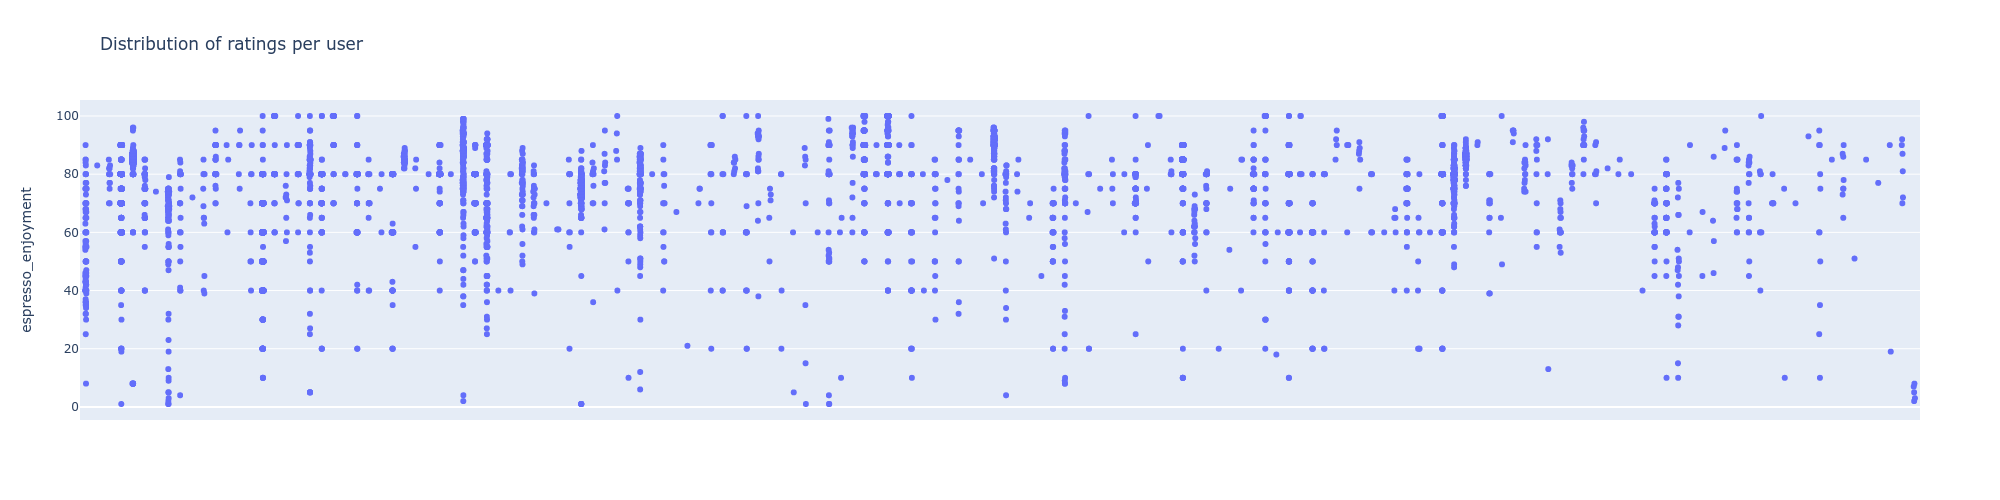

In [18]:
fig = px.strip(shots_df[shots_df["espresso_enjoyment"]!=0].sort_values("start_time"), 
               x="user_id", y="espresso_enjoyment",
               height=500,width=2000,
               title="Distribution of ratings per user, sorted by `start_time`")
fig.update_xaxes(
    visible=False
)
fig.show(renderer="png")

In [9]:
most_popular_profiles = shots_df["profile_title"].value_counts()[:20]
most_popular_profiles

Default                          5110
Damian's LRv3                    5101
Londonium                        3805
Damian's LRv2                    3627
Gentle and sweet                 3128
Blooming Espresso                2696
Best overall pressure profile    2207
Best practice (medium roast)     2173
Adaptive (for medium roasts)     2099
Rao Allongé                      1973
Cremina lever machine            1741
Nu Skool Espresso v3             1251
DEK/Blooming Espresso             740
Gagné/Adaptive Shot 94C v1.0      706
Traditional lever machine         690
Best practice (light roast)       646
Tea portafilter/black tea         589
Hendon Turbo 6b Decline           583
Classic Italian espresso          554
TurboBloom                        549
Name: profile_title, dtype: int64

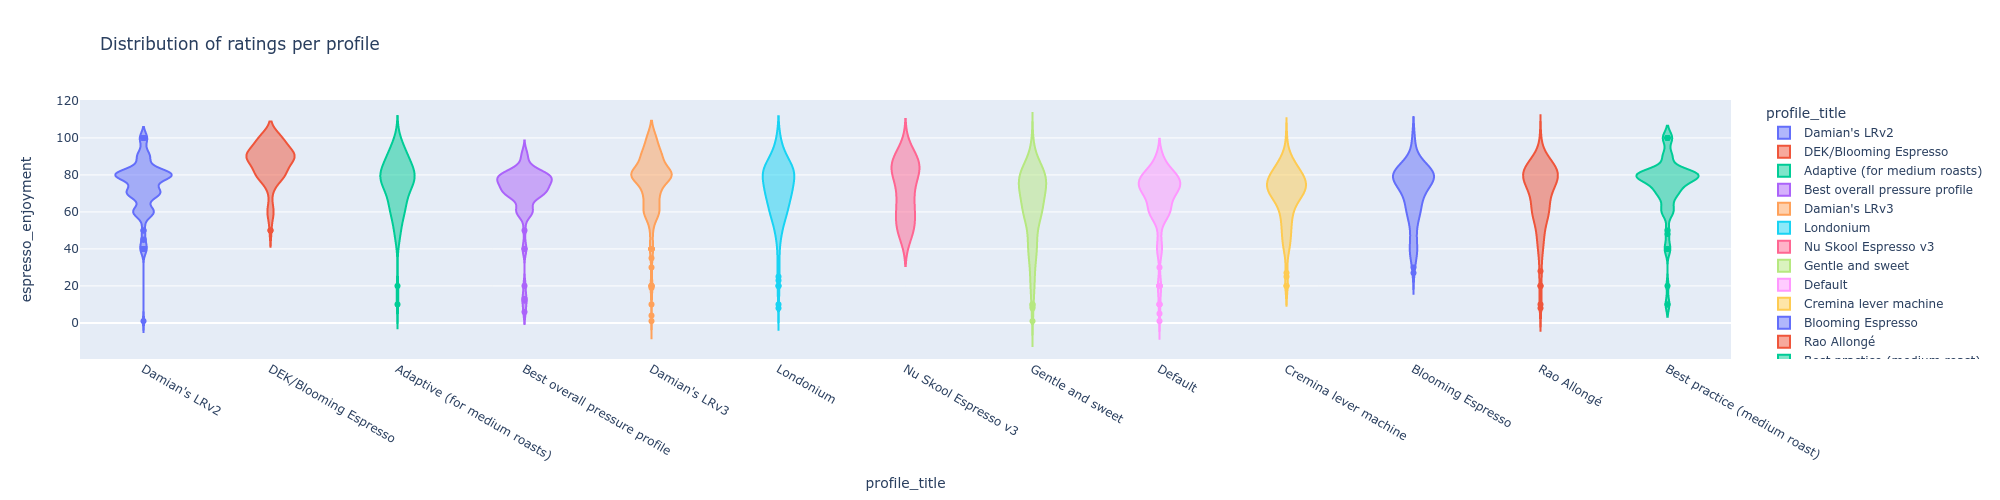

In [17]:
df = shots_df[shots_df["profile_title"].isin(most_popular_profiles.index[:14])]
df = df[df["espresso_enjoyment"]!=0]
fig = px.violin(df, x="profile_title", y="espresso_enjoyment", #facet_col="profile_title",
               height=500,width=2000, color="profile_title",
               title="Distribution of ratings per profile")
fig.show(renderer="png")

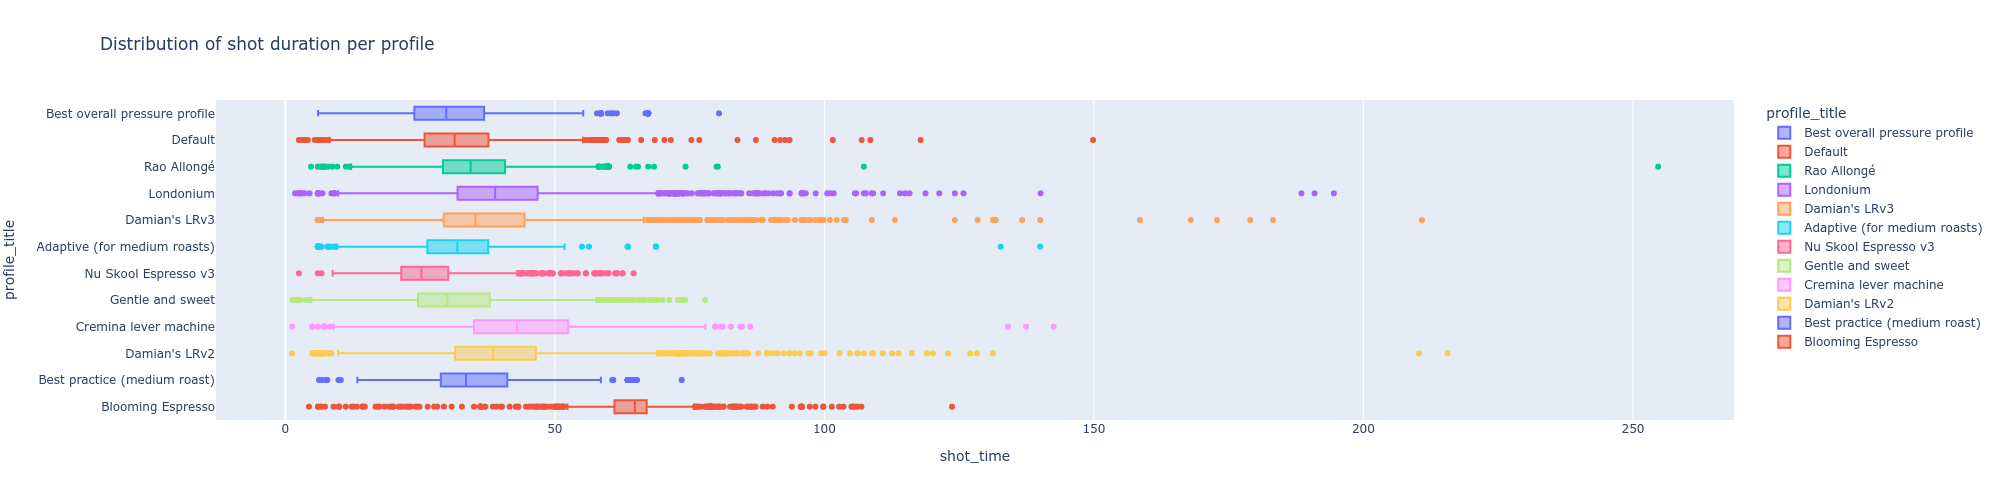

In [14]:
df = shots_df[shots_df["profile_title"].isin(most_popular_profiles.index[:12])]

fig = px.box(df, x="shot_time", y="profile_title", #facet_col="profile_title",
               height=500, width=2000, color="profile_title",
               title="Distribution of shot duration per profile")
fig.show(renderer="png")

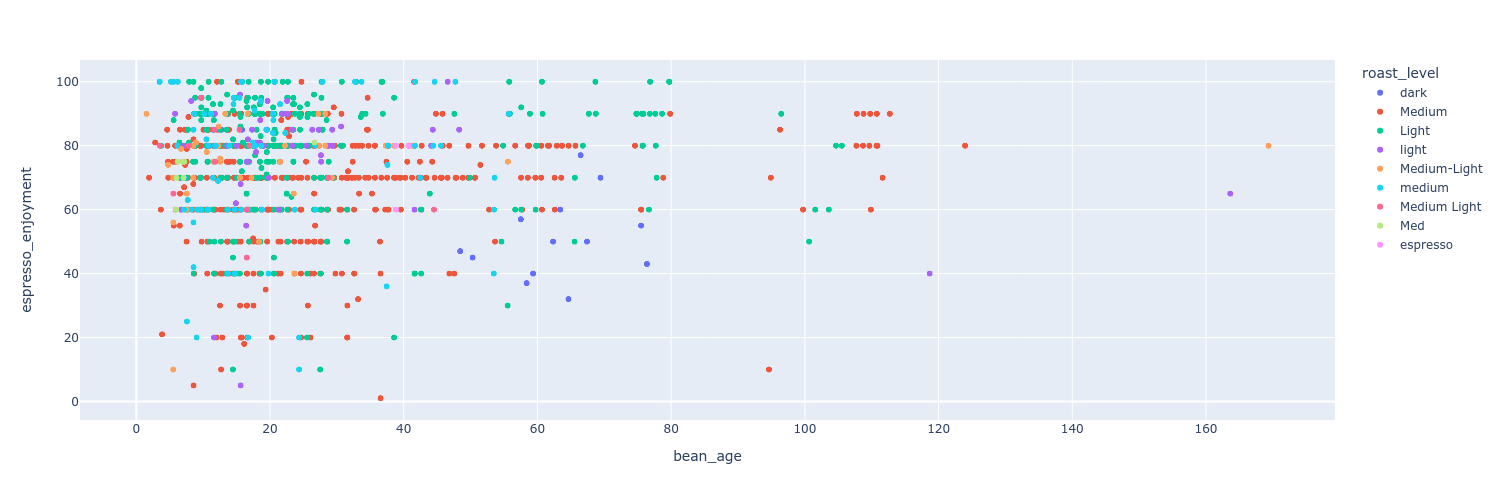

In [16]:
px.scatter(shots_df[(shots_df["espresso_enjoyment"]!=0) & shots_df["roast_level"].isin(['Medium', 'Light', 'medium', 
                                                                                        'light', 'dark', 'Med', 'espresso',
                                                                                        'Medium-Light', 'Medium Light'])], 
           x="bean_age", y="espresso_enjoyment", color="roast_level", width=1500).show(renderer="png")

# Visualize shot series

In [33]:
timeseries_cols = ["timeframe", 'espresso_flow',
       'espresso_weight', 'espresso_pressure', 'espresso_flow_goal',
       'espresso_resistance', 'espresso_flow_weight', 'espresso_state_change',
       'espresso_pressure_goal', 'espresso_flow_weight_raw',
       'espresso_temperature_mix', 'espresso_water_dispensed',
       'espresso_temperature_goal', 'espresso_resistance_weight',
       'espresso_temperature_basket']

In [106]:
def timeframe_to_series(values, timeframe):
    time_index = pd.TimedeltaIndex(timeframe, unit="seconds")
    
    some_series = values[list(values.keys())[0]]

    if some_series.shape[0] < time_index.shape[0]:
        print(some_series.shape, time_index.shape)
        time_index = time_index[:some_series.shape[0]]

    return pd.DataFrame(values, index=pd.TimedeltaIndex(time_index, unit="seconds"))

In [108]:
shots_df[timeseries_cols].iloc[i:i+1].apply(lambda x: timeframe_to_series(x[1:].to_dict(), timeframe=x.timeframe), axis=1).iloc[0]

(114,) (115,)


,espresso_flow,espresso_weight,espresso_pressure,espresso_flow_goal,espresso_resistance,espresso_flow_weight,espresso_state_change,espresso_pressure_goal,espresso_flow_weight_raw,espresso_temperature_mix,espresso_water_dispensed,espresso_temperature_goal,espresso_resistance_weight,espresso_temperature_basket
0 days 00:00:00,0.00,0.0,0.00,-1.0000,None,0.00,0.0,-1.0,0.00,199.40,0.000000,199.4,None,199.40
0 days 00:00:00.043000,3.90,0.0,0.36,7.9375,None,0.00,10000000.0,-1.0,0.00,200.20,0.081233,199.4,None,195.63
0 days 00:00:00.225000,4.69,0.0,0.39,7.9375,None,0.00,10000000.0,-1.0,0.00,199.84,0.179026,199.4,None,195.93
0 days 00:00:00.448000,5.58,0.0,0.45,8.0000,None,0.00,10000000.0,-1.0,0.00,194.84,0.295349,199.4,None,196.07
0 days 00:00:00.629000,6.35,0.0,0.52,8.0000,None,0.00,10000000.0,-1.0,0.00,192.52,0.427572,199.4,None,195.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 00:00:22.543000,3.00,34.7,6.99,3.0000,None,3.91,-10000000.0,-1.0,3.91,187.05,7.748199,190.4,None,191.47
0 days 00:00:22.768000,3.01,35.5,6.90,3.0000,None,4.01,-10000000.0,-1.0,4.01,186.88,7.810822,190.4,None,191.37
0 days 00:00:22.947000,2.97,36.3,6.94,3.0000,None,3.91,-10000000.0,-1.0,3.91,186.76,7.872737,190.4,None,191.25
0 days 00:00:23.263000,2.98,37.5,6.91,3.0000,None,3.91,-10000000.0,-1.0,3.91,186.88,7.934728,190.4,None,191.28


In [83]:
for i in range(100):
    lengths = shots_df[timeseries_cols][i:i+1].apply(lambda x: len(x.iloc[0]), axis=0)
    print(i, "\n", lengths)


0 timeframe                      76
espresso_flow                  76
espresso_weight                76
espresso_pressure              76
espresso_flow_goal             76
espresso_resistance            76
espresso_flow_weight           76
espresso_state_change          76
espresso_pressure_goal         76
espresso_flow_weight_raw       76
espresso_temperature_mix       76
espresso_water_dispensed       76
espresso_temperature_goal      76
espresso_resistance_weight     76
espresso_temperature_basket    76
dtype: int64
1 timeframe                      272
espresso_flow                  120
espresso_weight                120
espresso_pressure              120
espresso_flow_goal             120
espresso_resistance            120
espresso_flow_weight           120
espresso_state_change          120
espresso_pressure_goal         120
espresso_flow_weight_raw       120
espresso_temperature_mix       120
espresso_water_dispensed       120
espresso_temperature_goal      120
espresso_resistanc

TypeError: object of type 'NoneType' has no len()

In [54]:
shots_df.iloc[1][["timeframe", "espresso_flow", "espresso_flow_goal"]][1:].apply(lambda x: print(x), axis=1)

TypeError: <lambda>() got an unexpected keyword argument 'axis'

In [ ]:
shots_df

In [28]:
series_df = shots_df.iloc[0]

# time_index = np.roll(time_index, shift=-1)
# time_index[-1] = time_index[-2]

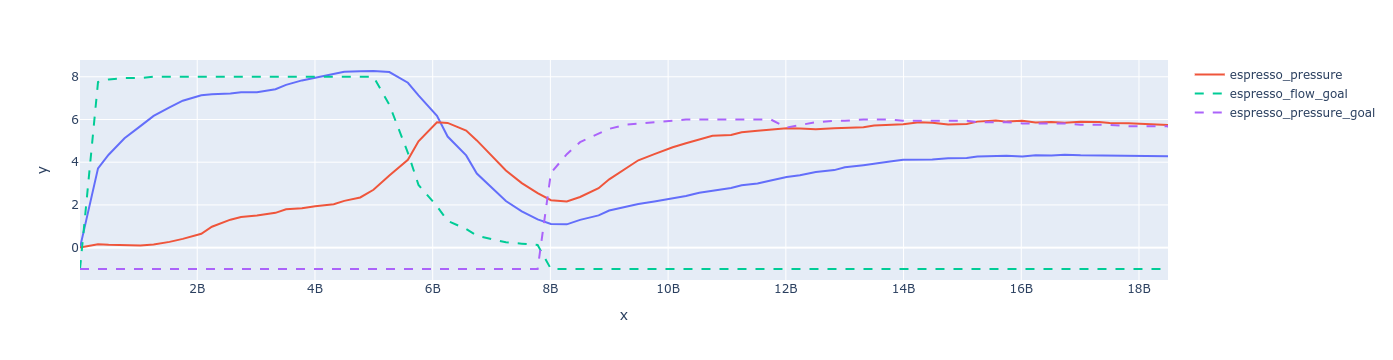

In [26]:
fig = px.line(x=time_index, y=series_df["espresso_flow"])
fig.add_scatter(x=time_index, y=series_df['espresso_pressure'], mode='lines', name="espresso_pressure")
fig.add_scatter(x=time_index, y=series_df['espresso_flow_goal'], mode='lines', name="espresso_flow_goal", line={"dash": "dash"})
fig.add_scatter(x=time_index, y=series_df['espresso_pressure_goal'], mode='lines', name="espresso_pressure_goal", line={"dash": "dash"})
fig.update_layout(hovermode="x")
fig